In [1]:
!pip install neo4j
!pip install python-igraph
!pip install easygui
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 536 kB/s 
  Created wheel for neo4j: filename=neo4j-4.4.3-py3-none-any.whl size=116069 sha256=a1b558da9398d089c0c79c152572f25b7aa4e8f062c2ac2803155936b89da7d8
  Stored in directory: /root/.cache/pip/wheels/db/dd/76/acacd519878f133f2f869aec70db548d89e04013209c3c62bc
Successfully built neo4j
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 537 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.8 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=cbd2af3

In [2]:
from neo4j import GraphDatabase
import igraph as ig
from skimage.io import imread
import glob
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import warnings
import random
import numpy as np
import random
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
z = ig.Graph.Read_GraphML("/content/drive/My Drive/ALSSN/zurich.graphml")

In [ ]:
z.edge_attributes(), z.vertex_attributes()

(['weight', 'label', 'id'], ['location', 'id', 'labels'])

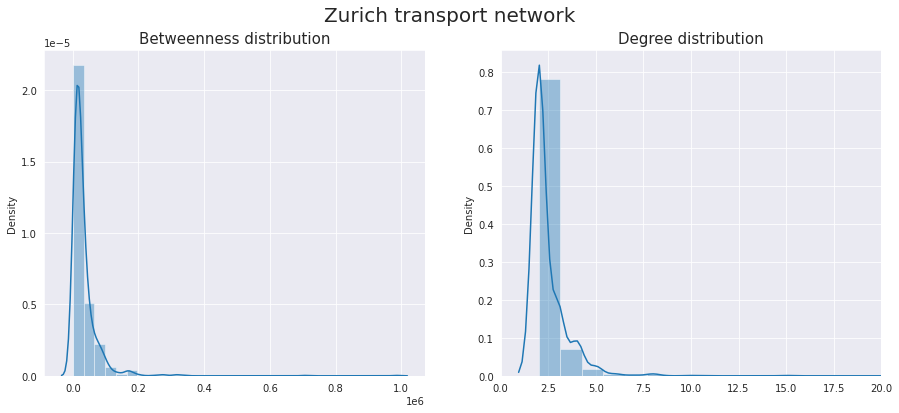

In [5]:
btw = z.betweenness()
deg = z.degree()
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
plt.suptitle('Zurich transport network', fontsize=20)
plt.subplot(121)
sns.distplot(btw, bins=30)
plt.ticklabel_format(axis='x', style='sci', scilimits=[0, .6])
plt.title('Betweenness distribution', fontsize=15)
plt.subplot(122)
sns.distplot(deg, bins=30)
plt.xlim([0,20])
plt.title('Degree distribution', fontsize=15);


In [6]:
z.vcount(), z.is_directed(), z.is_weighted()

(1346, True, True)

In [ ]:
# for c in glob.glob('*png'):
#   os.remove(c)

In [7]:
def generate_graph(graph, modules, iteration=None, delete_previous_plots=True, layout='auto'):
  if not os.path.exists('clusters/'):
    os.mkdir('clusters/')
    
  if delete_previous_plots and iteration==1:
    for c in glob.glob('clusters/cluster*png'):
      os.remove(c)

  layout_gr = graph.layout(layout)

  colors =np.random.permutation(sns.color_palette("hls", len(modules))).tolist()
  #colors = sns.color_palette("hls", k)
  graph.vs['color'] = [None]
  for clid, cluster in enumerate(modules):
      for member in cluster:
          graph.vs[member]['color'] = colors[clid]

  visual_style = {}
  visual_style["vertex_size"] = 5
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (300, 300)
  pl = ig.plot(graph, **visual_style)
  if iteration:
    pl.save('clusters/clusters_{}_iter{}.png'.format(len(modules), iteration))
  else:
    pl.save('clusters/clusters_{}.png'.format(len(modules)))
  #return pl

def plot_graphs(img_path='clusters/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'cluster*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][4:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//2
    cols = len(img_list)//4 + 1
  else:
    rows = len(img_list)//2
    cols = len(img_list)//4

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'iteration ' + imf.split('_')[-1][4:-4] + '\n' +'n_clusters: ' + imf.split('_')[1] 
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

Analysis carried out by iteratively removing the node with the highest betweenness centrality. At each iteration the following metrics are computed: communities with Leiden algorithm, shortest paths between pairs of selected nodes, modularity and betweenness measures 

In [16]:
def get_most_central_node(subgraph, ref_ids=[], method='bwt'):
  # ref ids are the list of nodes that we do not want to remove from our graphs because they represent the nodes between which we want to compute the shortest paths
  if method=='btw':
    # Approach of most central node selection taken from excercise session 3
    betw = subgraph.betweenness()
    # Select node with the highest degree and betweenness
    vid = subgraph.vs[np.where(betw==np.amax(betw))[0][0]].index
    while vid in ref_ids:
      betw.remove(np.amax(betw))
      vid = subgraph.vs[np.where(betw==np.amax(betw))[0][0]].index

  elif method=='eig_cent':
    cent = subgraph.eigenvector_centrality()
    vid = subgraph.vs[np.argmax(cent)].index
    while vid in ref_ids:
      cent.remove(np.amax(cent))
      vid = subgraph.vs[np.argmax(cent)].index
  return vid

In [17]:
def compute_shortest_path(graph, pairs):
  shortest_paths = {}
  for p in pairs:
    w = [1/i for i in graph.es["weight"]]
    shortest_paths[str(p)] = graph.get_shortest_paths(p[0], to=p[1], weights=w, output="vpath",)
  return shortest_paths

def process(graph_undirected, pairs, ref_ids=[], iterations=10, save_plots=True):
  metrics = pd.DataFrame(columns=['subgraph', 'modules', 'iteration', 'betweenness', 'shortest_path', 'modularity'])
  for i in range(iterations):
    if i==0:
      # in the first iteration we don't remove anything, we just compute the baseline measures
      subgraph = graph_undirected.copy() #.clusters().giant()################
      msg = 'number of nodes: {}, number of edges: {}'.format(subgraph.vcount(), subgraph.ecount())
    else:
      # get most central vertex
      v_id = get_most_central_node(subgraph, ref_ids, method='btw') 
      # remove from subgraph
      subgraph.delete_vertices(v_id)
      msg = 'removed node: {}, number of nodes: {}, number of edges: {}'.format(v_id, subgraph.vcount(), subgraph.ecount())
    leid = subgraph.community_leiden(weights=subgraph.es["weight"], resolution_parameter=.5) #the lower the less communities
    row = pd.Series(data = {'subgraph': subgraph.copy(), 
                          'iteration': i, 
                          'modules': leid,
                          'betweenness': subgraph.betweenness(),
                          'shortest_paths':compute_shortest_path(subgraph, pairs), 
                          'modularity': leid.modularity,
                          'n_clusters': len(leid)})
    #communities = lvn.subgraphs()
    metrics = metrics.append(row, ignore_index=True)
    if save_plots:
      generate_graph(subgraph, leid, iteration=i+1, layout='drl')
    print(msg)
  return metrics

In [21]:
def associate_internal_ids(substop_id_df_path):
  # reads the dataframe containing the substop names and id and provide it with the igraph internal indexing
  touristic_substops = pd.read_excel(substop_id_df_path)
  #ref_ids = random.sample(touristic_substops['ID SUBSTOP'].to_list(), 4)
  ref_node_ids = []
  for v in z.vs:
    if int(v['id']) in touristic_substops['ID SUBSTOP'].to_list():
      ref_node_ids.append(v.index)
  touristic_substops['internal_id'] = ref_node_ids
  return touristic_substops

In [26]:
def generate_random_pairs(n_sample, graph, source_list=[]):
  # random pairs of nodes to be considered as ends of the shortest paths to monitor. can be selected randomly from the graph or from a given list of node ids
  if not source_list:
    print("selecting {} random nodes as reference nodes ".format(n_sample))
    nextr = random.sample(range(graph.vcount()), n_sample)
  else:
    nextr = random.sample(source_list, n_sample)
  pairs = [(nextr[i], nextr[i+1]) for i in range(0, n_sample, 2)] 
  return pairs, nextr

In [27]:
# convert network to undirected in order to perform the Louvain algorithm
touristic_substops = associate_internal_ids('/content/drive/My Drive/ALSSN/touristic_substops.xlsx')
pairs, ref_node_ids = generate_random_pairs(8, z, touristic_substops['internal_id'].to_list())
z_undirected = z.copy()
z_undirected.to_undirected(combine_edges=dict(weight="sum"))
metrics = process(z_undirected, pairs, ref_node_ids, iterations=50, save_plots=True)

number of nodes: 1346, number of edges: 1657
removed node: 765, number of nodes: 1345, number of edges: 1636
removed node: 586, number of nodes: 1344, number of edges: 1609


SystemError: ignored

### Graph topology changes across iterations

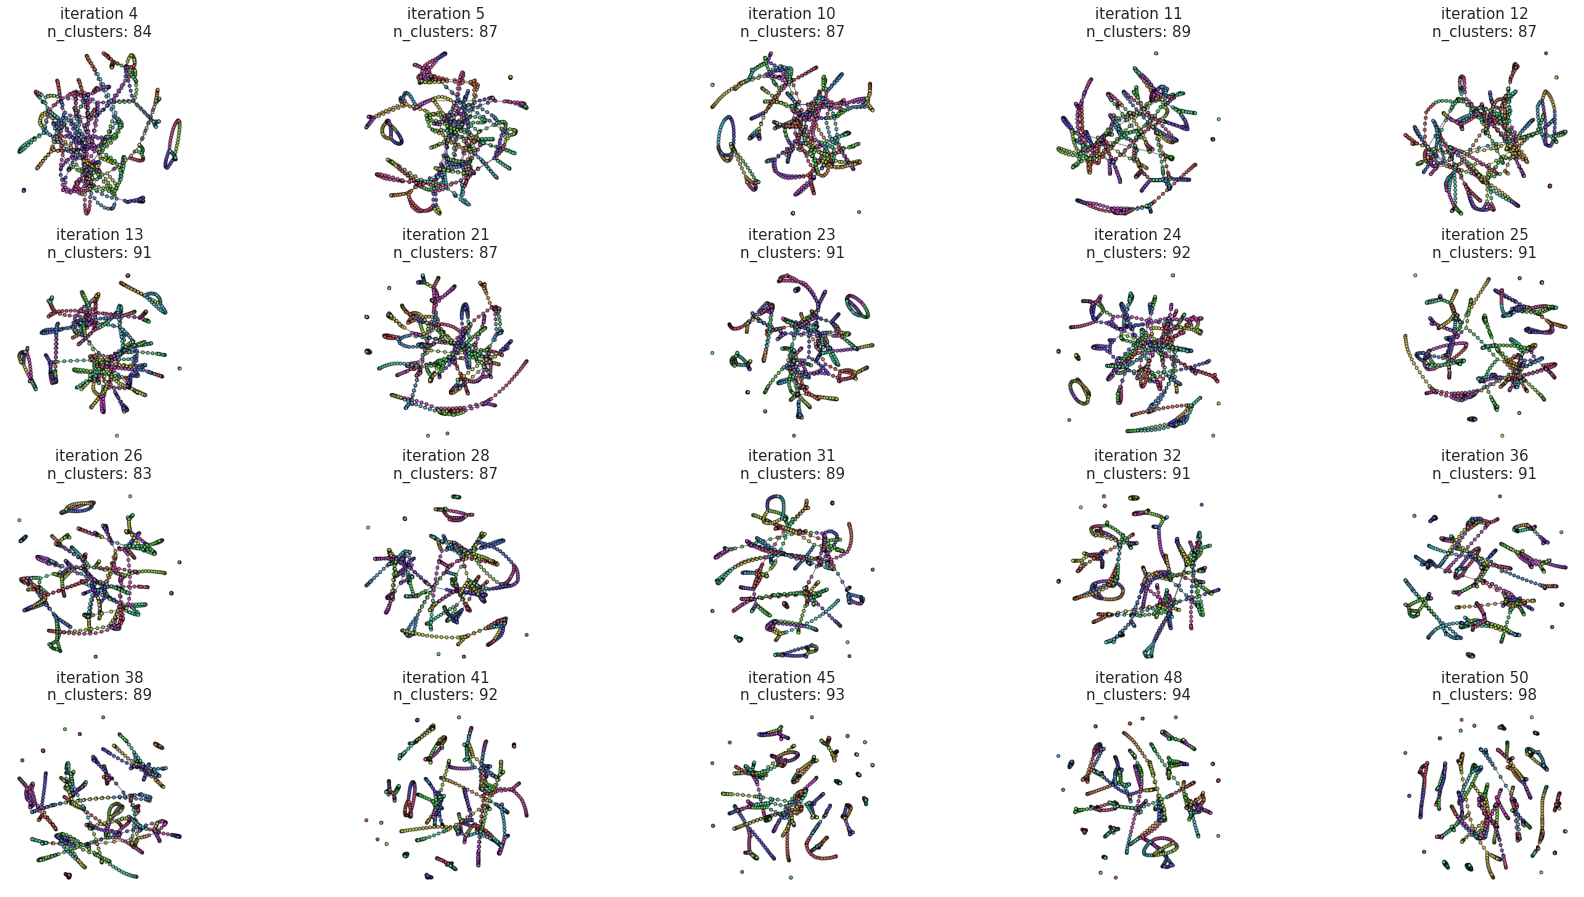

In [ ]:
plt.figure(figsize=(30, 40))
plot_graphs(sample=True)

Clusters become more and more separated across iterations as expected. we should check whether we get to a condition in which we have pretty well separated clusters consisting of multiple nodes (i.e. not only one node clusters)

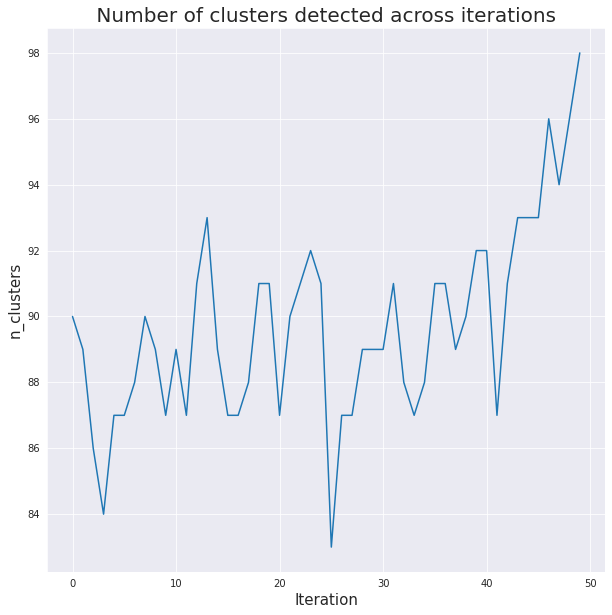

In [ ]:
plt.figure(figsize=(10,10))
s = sns.lineplot(x='iteration', y='n_clusters', data=metrics)
s.set_xlabel("Iteration",fontsize=15)
s.set_ylabel("n_clusters",fontsize=15)
plt.title(" Number of clusters detected across iterations ", fontsize=20);

### Shortest path changes between node pairs across iterations

In [ ]:
def shortest_path_graph(graph, gspaths, iteration, delete_previous_plots=True):
  """
  graph: current subgraph or main graph 
  gspaths: all the graph shortest paths being monitored at the current iteration
  """
  if not os.path.exists('shortest_paths/'):
    os.mkdir('shortest_paths/')

  if delete_previous_plots and iteration==1:
    for c in glob.glob('shortest_paths/spaths*png'):
      os.remove(c)

  # set default layout properties
  layout_gr = graph.layout('drl')
  colors =sns.color_palette("hls", len(gspaths))
  graph.vs['color'] = ['black']
  graph.vs['size'] = 2

  i = 0

  # iterate over all the node pairs for which the shortest path are computed at each iteration 
  for spaths in gspaths:
        # pick paths related to one pair of node in the list
        paths = gspaths[spaths]
        # each pair might contain more than one shortest path (not sure why...but it returns a list)
        for path in paths:
          # assign properties to highlight all the paths associated to the analysed pair of nodes. 
          for n in path:
            graph.vs[n]['color'] = colors[i]
            graph.vs[n]['size'] = 10
        i+=1
  visual_style = {}
  visual_style["vertex_size"] = graph.vs['size']
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (400, 400)
  pl = ig.plot(graph, **visual_style)
  pl.save('shortest_paths/spaths_iteration_{}.png'.format(iteration))

def plot_shortest_paths(img_path='shortest_paths/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'spaths*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//2
    cols = len(img_list)//4 + 1
  else:
    rows = len(img_list)//2
    cols = len(img_list)//4

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'shortest paths iteration ' + imf.split('_')[-1][:-4]
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

In [ ]:
ref_graph = metrics.loc[0, 'subgraph']
for r in metrics.to_dict(orient="records"):
  shortest_path_graph(ref_graph, r['shortest_paths'], r['iteration'])
  #shortest_path_graph(r['subgraph'], r['shortest_paths'], r['iteration'])

In [ ]:
for r in metrics.to_dict(orient="records"):
  spaths=r['shortest_paths']
  msg = ', '.join(['ITER{}, modularity:{}'.format(r['iteration'], round(r['modularity'], 2))] + ['n_nodes for {}: {}'.format( i, len(max(spaths[i], key=len))) for i in spaths])
  print(msg)

ITER0, modularity:0.87, n_nodes for (548, 314): 25, n_nodes for (1211, 104): 40, n_nodes for (1002, 984): 24, n_nodes for (623, 878): 9
ITER1, modularity:0.87, n_nodes for (548, 314): 25, n_nodes for (1211, 104): 39, n_nodes for (1002, 984): 0, n_nodes for (623, 878): 9
ITER2, modularity:0.87, n_nodes for (548, 314): 25, n_nodes for (1211, 104): 40, n_nodes for (1002, 984): 0, n_nodes for (623, 878): 9
ITER3, modularity:0.87, n_nodes for (548, 314): 25, n_nodes for (1211, 104): 41, n_nodes for (1002, 984): 0, n_nodes for (623, 878): 9
ITER4, modularity:0.87, n_nodes for (548, 314): 26, n_nodes for (1211, 104): 42, n_nodes for (1002, 984): 0, n_nodes for (623, 878): 9
ITER5, modularity:0.87, n_nodes for (548, 314): 32, n_nodes for (1211, 104): 37, n_nodes for (1002, 984): 0, n_nodes for (623, 878): 6
ITER6, modularity:0.87, n_nodes for (548, 314): 32, n_nodes for (1211, 104): 36, n_nodes for (1002, 984): 0, n_nodes for (623, 878): 6
ITER7, modularity:0.87, n_nodes for (548, 314): 33, n_

modularity does not jump when no more shortest paths are found. probably we should rely more on the shortest path computation as convergence method

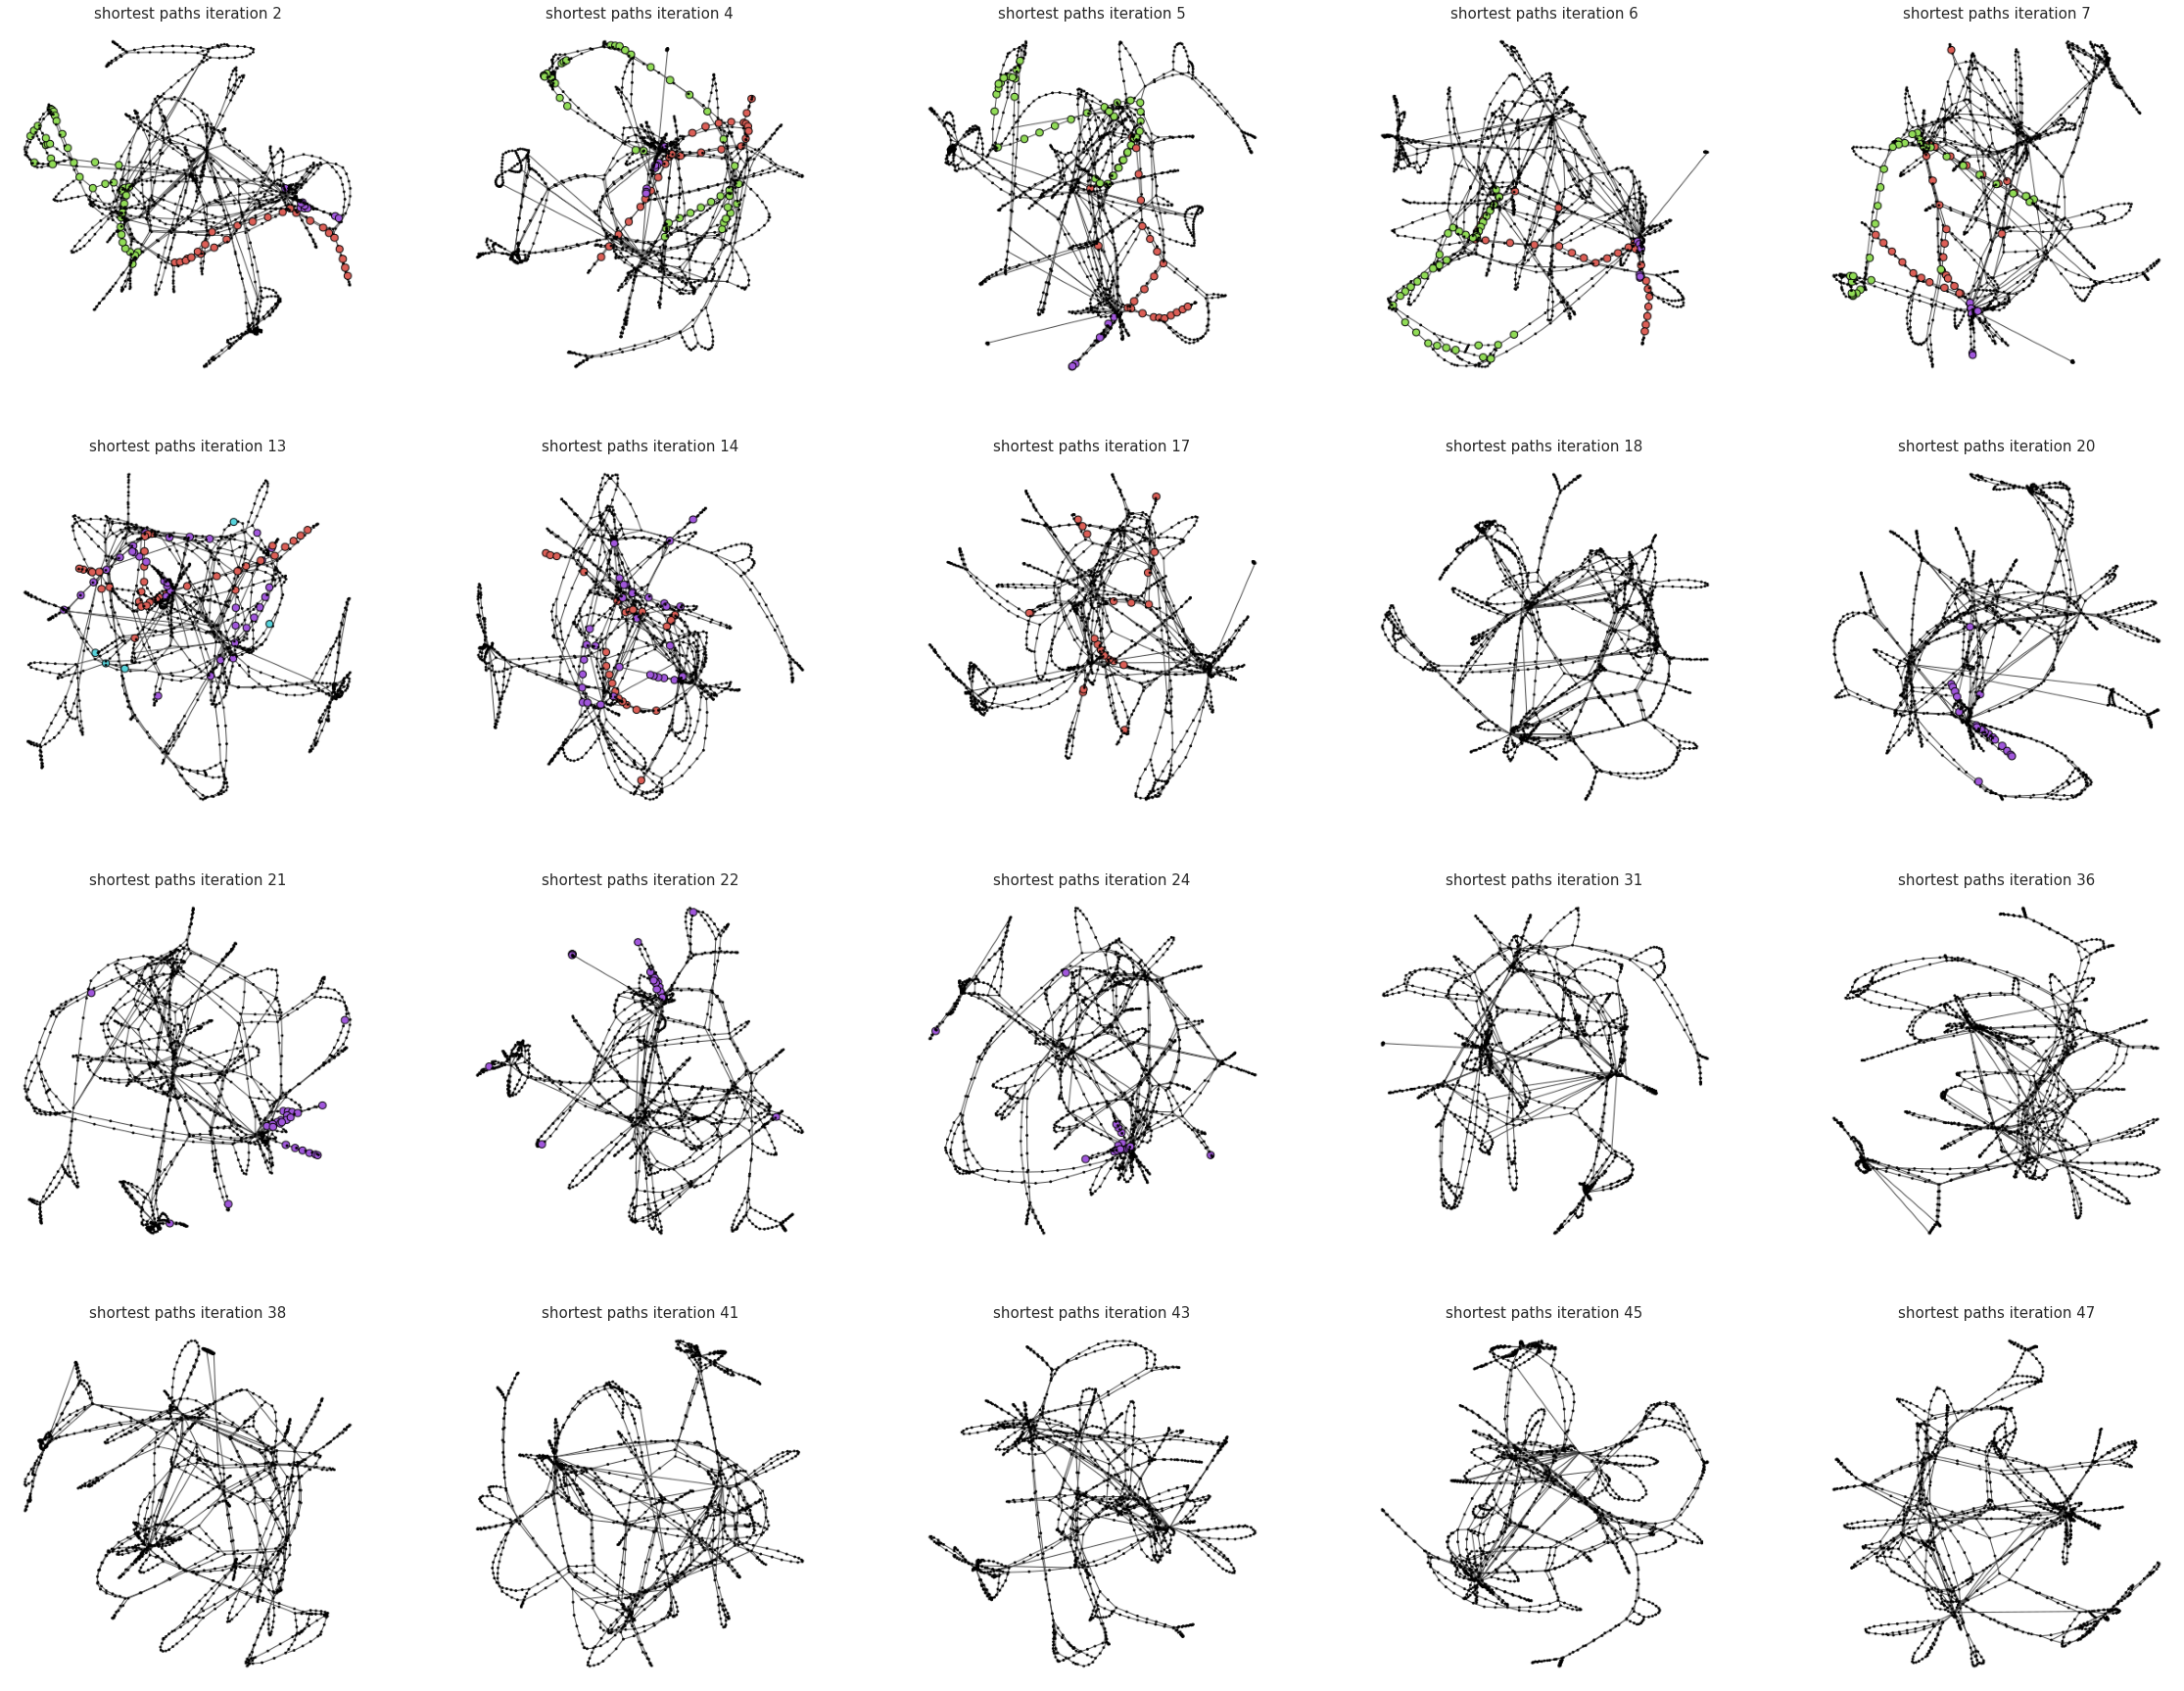

In [ ]:
plt.figure(figsize=(40, 80))
plot_shortest_paths()

3) Approach of most central node selection taken from excercise session 3

In [ ]:
# z_undirected = z.copy()
# z_undirected.to_undirected()
# lvn = z_undirected.community_multilevel()
# lvn.modularity
# communities = lvn.subgraphs()

# def getCentralSubStops(subgraph):
#   wdeg = subgraph.strength()
#   betw = subgraph.betweenness()
#   ## Select nodes which belong to the top 5% most central nodes based on both weighted degree and betweenness
#   centrals = subgraph.es[np.where((wdeg>=np.percentile(wdeg,95))& (betw>=np.percentile(betw, 95)))[0].tolist()]
#   return centrals
# centrals = getCentralSubStops(communities[0])
# print(centrals)